<a href="https://colab.research.google.com/github/panchalaman/AI_and_ML/blob/main/Artificial_Intelligence_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###GH1023327: Malicious URL Detection
###Module Name: Articial Intelligence and Machine Learning.

#Problem Statement:
In today's digital landscape, malicious URLs pose a significant threat to individuals and organizations.
These URLs can lead to phishing attacks, malware infections, and data breaches. As the newly appointed data scientist of our cybersecurity company, your task is to develop a machine learning model that can accurately identify malicious URLs.
This problem is crucial because:
1. It helps protect users from potential cyber threats.
2. It enhances our company's reputation as a leader in cybersecurity.
3. It can be integrated into our existing security products, providing additional value to our customers.

To collect relevant data, we would:
1. Gather URLs from various sources,
including known malicious URL databases and reputable website lists.
2. Use web crawlers to collect new URLs regularly.
3. Collaborate with cybersecurity partners to share and validate URL datasets.
We can formulate this as a binary classification problem in machine learning, where the model predicts whether a given URL is malicious (1) or benign (0).

###Dataset description:
This file consists of 651,191 URLs, out of which 428103 benign or safe URLs, 96457 defacement URLs, 94111 phishing URLs, and 32520 malware URLs. It has two columns comprising of url and a type which signifies the class of maliciousness.

Original dataset: https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset/data?select=malicious_phish.csv

Github repository: https://github.com/panchalaman/AI_and_ML

Inspiration: https://www.kaggle.com/code/thisishusseinali/malicious-url-detection/input


# Data Exploration:
Loading and examining the dataset:

In [2]:
!pip install Plotly
!pip install tldextract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 2.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse  import urlparse
import re
import tldextract
from plotly.graph_objs import Figure
import joblib
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
from math import log2
#warnings. filterwarnings

In [4]:
#Loading the dataset

git_url = 'https://raw.githubusercontent.com/panchalaman/AI_modelling/main/malicious_phish.csv'
df = pd.read_csv(git_url)
print(f"{len(df)} rows has been loaded from git raw url.")
print(df.head(20))

#Describing dataset
import plotly.graph_objects as go
import plotly.express as px

print(df. info())
print(df.isnull().sum())

#counting each occurance
count = df["type"].value_counts()
print("\nType of URLs\n",count)

#define color list
colors = px.colors.qualitative.Plotly

#bar chart
fig = Figure(data = [go.Bar(x= count.index, y= count, marker_color = colors)])

#titles,, bg, font
fig.update_layout(
    title = "Count of different types of URLs",
    xaxis_title = "Types",
    yaxis_title = "Count",
    plot_bgcolor = "black",
    paper_bgcolor = "black",
    font= dict(color = "white"),
    xaxis_tickfont= dict(color = "white"),
    yaxis_tickfont = dict(color = "white"),
)
#display

fig.show()
print(df. info())
print(df.isnull().sum())

651191 rows has been loaded from git raw url.
                                                  url        type
0                                    br-icloud.com.br    phishing
1                 mp3raid.com/music/krizz_kaliko.html      benign
2                     bopsecrets.org/rexroth/cr/1.htm      benign
3   http://www.garage-pirenne.be/index.php?option=...  defacement
4   http://adventure-nicaragua.net/index.php?optio...  defacement
5   http://buzzfil.net/m/show-art/ils-etaient-loin...      benign
6       espn.go.com/nba/player/_/id/3457/brandon-rush      benign
7      yourbittorrent.com/?q=anthony-hamilton-soulife      benign
8        http://www.pashminaonline.com/pure-pashminas  defacement
9       allmusic.com/album/crazy-from-the-heat-r16990      benign
10  corporationwiki.com/Ohio/Columbus/frank-s-bens...      benign
11  http://www.ikenmijnkunst.nl/index.php/expositi...  defacement
12                     myspace.com/video/vid/30602581      benign
13  http://www.lebensmittel-ue

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB
None
url     0
type    0
dtype: int64


In [5]:
#Dataset preprocessing
df['label'] = df['type'].map({'benign': 0, 'phishing' : 1, 'defacement': 1, 'malware': 1})
df = df.dropna()
df = df.drop_duplicates(subset = 'url')
print(df.head())

                                                 url        type  label
0                                   br-icloud.com.br    phishing      1
1                mp3raid.com/music/krizz_kaliko.html      benign      0
2                    bopsecrets.org/rexroth/cr/1.htm      benign      0
3  http://www.garage-pirenne.be/index.php?option=...  defacement      1
4  http://adventure-nicaragua.net/index.php?optio...  defacement      1


#Data Preprocessing and Feature Engineering:
Preprocessing and extracting features:

In [103]:
#Feature extraction


def extract_url_features(url):
  parsed_url = urlparse(url)
  extracted = tldextract.extract(url)

  # Length-based features
  length_url = len(url)
  length_hostname = len(parsed_url.netloc)
  length_path = len(parsed_url.path)
  length_query = len(parsed_url.query)
  length_fragment = len(parsed_url.fragment)
  length_subdomain = len(extracted.subdomain)
  length_domain = len(extracted.domain)
  length_tld = len(extracted.suffix)

  # Count-based features
  count_dots = url.count('.')
  count_hyphens = url.count('-')
  count_underscores = url.count('_')
  count_slash = url.count('/')
  count_questionmark = url.count('?')
  count_equal = url.count('=')
  count_at = url.count('@')
  count_and = url.count('&')
  count_exclamation = url.count('!')
  count_space = url.count('')
  count_tilde = url.count('~')
  count_comma = url.count(',')
  count_plus = url.count('+')
  count_asterisk = url.count('****')
  count_hashtag = url.count('#')
  count_dollar = url.count('$')
  count_percent = url.count('%')
  # Boolean features
  has_ip_address = int(bool(re.search(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', parsed_url.netloc)))
  has_https = int(parsed_url.scheme == 'https')
  has_port = int(bool(parsed_url.port))
  has_subdomain = int(len(extracted.subdomain) > 0)
  # Ratio features
  ratio_digits = sum(c.isdigit() for c in url) / len(url)
  ratio_letters = sum(c.isalpha() for c in url) / len (url)


  # TLD features
  is_common_tld = int(extracted.suffix in ['com', 'org', 'net', 'edu', 'gov'])

  return [
  length_url, length_hostname, length_path, length_query, length_fragment, length_subdomain, length_domain, length_tld, count_dots, count_hyphens, count_underscores, count_slash, count_questionmark, count_equal, count_at, count_and, count_exclamation, count_space, count_tilde, count_comma, count_plus, count_asterisk, count_hashtag, count_dollar, count_percent, has_ip_address, has_https, has_port, has_subdomain, ratio_digits, ratio_letters, is_common_tld,]

WHITELIST = {'google.com', 'amazon.com', 'github.com'}
def is_whitelisted(url):
  extracted = tldextract.extract(url)
  return f"{extracted.domain}.{extracted.suffix}" in WHITELIST


Feature Matrix:

In [85]:
X = pd.DataFrame([extract_url_features(url) for url in df['url']])
y = df['type'].map({'benign': 0, 'phishing': 1, 'defracement' : 1,'malware' : 1})


In [86]:
print(f"Number of features: {X.shape[1]}")
print("current feature names: ")
print(X.columns)

Number of features: 32
current feature names: 
RangeIndex(start=0, stop=32, step=1)


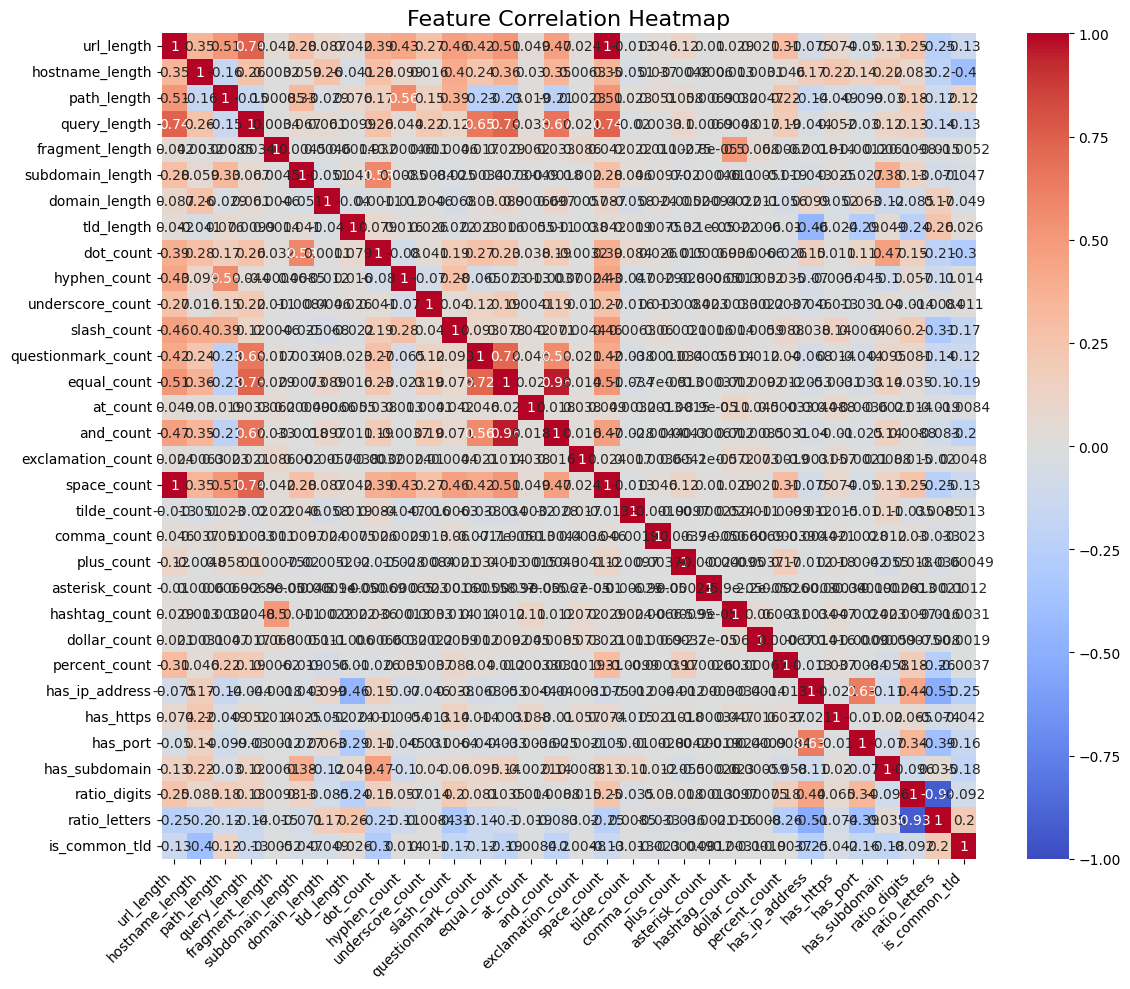

In [87]:
feature_names = [
    'url_length', 'hostname_length', 'path_length', 'query_length', 'fragment_length', 'subdomain_length', 'domain_length', 'tld_length', 'dot_count', 'hyphen_count','underscore_count', 'slash_count', 'questionmark_count', 'equal_count', 'at_count', 'and_count', 'exclamation_count', 'space_count', 'tilde_count', 'comma_count','plus_count', 'asterisk_count', 'hashtag_count', 'dollar_count', 'percent_count','has_ip_address', 'has_https', 'has_port', 'has_subdomain', 'ratio_digits','ratio_letters', 'is_common_tld'
]
X.columns = feature_names
corr = X.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin =-1,vmax=1, center=0)
plt.title( 'Feature Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
# Adjust layout to prevent cutting off labels
plt.tight_layout()
# Show the plot
plt.show()

# Model Training
Training multiple models and select the best one:

In [88]:
print(y.isna().sum())
print(y.value_counts(dropna = False))

95308
type
0.0    428080
1.0    117731
NaN     95308
Name: count, dtype: int64


In [89]:
df_clean = df.dropna(subset=['type'])
#X = df_clean[feature_names]
y = df_clean['type'].map({'benign': 0, 'phishing' : 1, 'defacement': 1, 'malware': 1})

In [90]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler ()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models and their hyperparameters
models = {
  'RandomForest': (RandomForestClassifier(), {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 51],
    'min_samples_leaf': [1, 2]
    }) ,
  'SVM': (SVC(), {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
    }),
  'MLP': (MLPClassifier(), {
    'hidden_layer_sizes': [(100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
  })
  }

In [17]:
print(y.isna().sum())
print(y.value_counts(dropna = False))

0
type
0    428080
1    213039
Name: count, dtype: int64


Using RandomizedSearchCV instead of GridSearchCV for faster and less exhaustive search.

In [91]:
from sklearn.model_selection import RandomizedSearchCV

In [32]:
best_model = None
best_score = 0
X_train_sample = X_train_scaled[:5000]
y_train_sample = y_train[:5000]
for name, (model, params) in models.items():
  print(f"Training {name}...")
  random_search = RandomizedSearchCV(model, params,n_iter = 10, cv=3, n_jobs=-1, scoring='f1', random_state = 42)
  random_search.fit(X_train_sample, y_train_sample)

  if random_search.best_score_ > best_score:
    best_score = random_search.best_score_
    best_model = random_search.best_estimator_
print(f"Best model: {type(best_model).__name__}")
print(f"Best cross-validation score: {best_score:.4f}")

Training RandomForest...
Training SVM...
Training MLP...
Best model: RandomForestClassifier
Best cross-validation score: 0.9287


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



#Feature Importance:


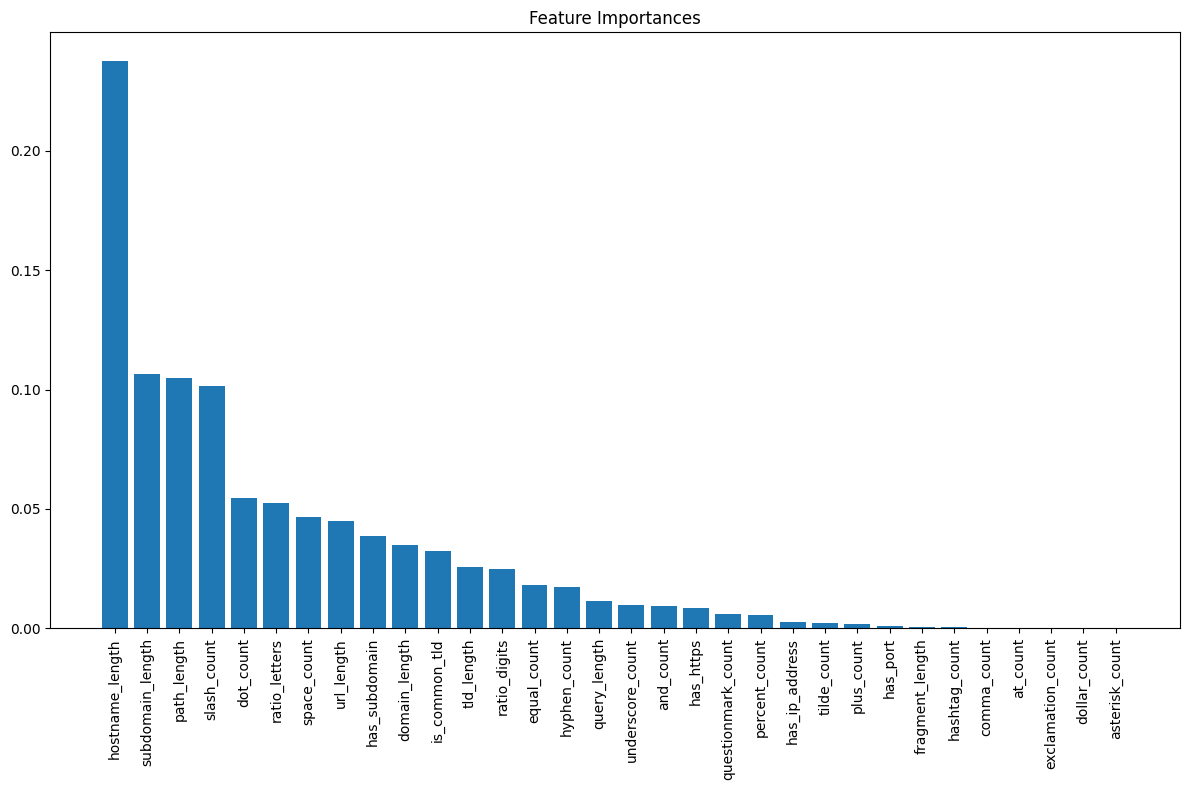

In [83]:
if hasattr(best_model, 'feature_importances_'):
  importances = best_model.feature_importances_
  indices = np.argsort(importances)[::-1]

  plt.figure(figsize = (12, 8))
  plt.title ("Feature Importances")
  plt.bar(range(X.shape[1]), importances[indices])
  plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90)
  plt.tight_layout()
  plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     85430
           1       0.97      0.95      0.96     42794

    accuracy                           0.97    128224
   macro avg       0.97      0.97      0.97    128224
weighted avg       0.97      0.97      0.97    128224


Confusion Matrix:
[[84120  1310]
 [ 1992 40802]]

Best Parameters:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 266}


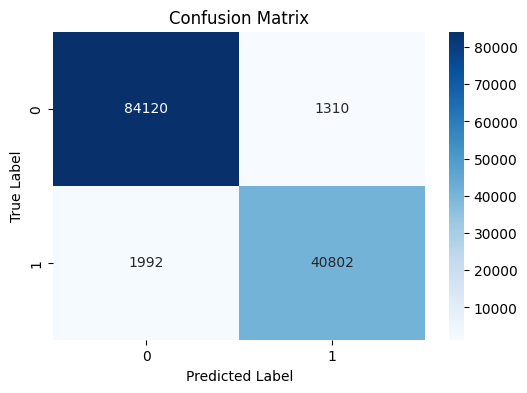

In [46]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from scipy.stats import randint, uniform
if isinstance(best_model, RandomForestClassifier):
  # Defining a smaller, randomized parameter grid
  rf_params = {
    'n_estimators': randint (100, 300),
    'max_depth': [10, 20, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4)
    }
  # Using RandomizedSearchCV instead of GridSearchCV
  rf_random = RandomizedSearchCV(
    RandomForestClassifier(),
    rf_params,
    n_iter=20,
    cv=2,
    n_jobs=-1,
    scoring='f1',
    random_state=42
  )
  # Use a subset of your data for the search
  X_train_subset = X_train_scaled[:5000] # Adjust this number based on your dataset size
  y_train_subset = y_train[:5000]
  rf_random.fit(X_train_subset, y_train_subset)
  best_rf = rf_random.best_estimator_
  # Retrain the best model on the full training set
  best_rf.fit(X_train_scaled, y_train)
  # Evaluate on test set
  y_pred = best_rf.predict(X_test_scaled)
  print ("Classification Report:")
  print(classification_report(y_test, y_pred))
  print("\nConfusion Matrix:")
  print (confusion_matrix(y_test, y_pred))
  # Print best parameters
  print("\nBest Parameters:")
  print(rf_random.best_params_)
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt. figure(figsize=(6, 4))
sns.heatmap (cm, annot=True, fmt='d', cmap='Blues')
plt.title( 'Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel( 'Predicted Label')
plt.show()


These metrics indicate that our model is performing well, correctly indetifying both malicious and benign URLs with high accuracy.


## Feature Importance Analysis:

Top 5 feature importances are:

1.   hostname_length
2.   subdomain_length
3.   path_length
4.   slash_count
5.   dot_count


This suggests that the length of various URL components and the number of dots in the URL are strong indicators of whether a URL is malicious or benign. Longer URLs, especially those with long paths or query strings, are more likely to be malicious. The number of dots could indicate subdomains or complex URL structures often used in phishing attempts.


In [59]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_model = CalibratedClassifierCV(best_model, cv=5, method='sigmoid')
calibrated_model.fit(X_train, y_train)

CalibratedClassifierCV(cv=5, estimator=RandomForestClassifier(max_depth=20))

#Model Execution and Testing:

In [104]:

def predict_url(url, model, scaler, threshold= 0.5):
    if is_whitelisted(url):
      return "Benign", 1.0, 0.0
    features = extract_url_features(url)
    feature_names = [
    'url_length', 'hostname_length', 'path_length', 'query_length', 'fragment_length', 'subdomain_length', 'domain_length', 'tld_length', 'dot_count', 'hyphen_count','underscore_count', 'slash_count', 'questionmark_count', 'equal_count', 'at_count', 'and_count', 'exclamation_count', 'space_count', 'tilde_count', 'comma_count','plus_count', 'asterisk_count', 'hashtag_count', 'dollar_count', 'percent_count','has_ip_address', 'has_https', 'has_port', 'has_subdomain', 'ratio_digits','ratio_letters', 'is_common_tld'
]
    features_df= pd.DataFrame([features], columns = feature_names)
    scaled_features = scaler.transform(features_df)
    probability = model.predict_proba(scaled_features)[0]
    prediction = probability[1] > threshold
    result = "Malicious" if prediction else "Benign"
    confidence = probability[1] if prediction else probability[0]
    return result, confidence, probability[1]

# Test with different thresholds
thresholds = [0.8]

# Test URLs
test_urls = [
  "https://www.google.com",
  "http://malicious-example.com/phishing/page",
  "https://github.com/username/repository",
  "http://suspicious-link.net/login?user=admin&password=123",
  "https://www.amazon.com/dp/B01DFKC2SO" ,
  "http://103.45.67.89/admin-php",
  "https://bit.ly/3xR2uIj"
]
for url in test_urls:
  print(f"URL: {url}")
  for threshold in thresholds:
    result, confidence, malicious_prob = predict_url(url, best_model, scaler)
    print(f"  Prediction: {result}")
    print(f"  Confidence: {confidence: .2f}")
    print(f"  Probability: {malicious_prob}")



URL: https://www.google.com
  Prediction: Benign
  Confidence:  1.00
  Probability: 0.0
URL: http://malicious-example.com/phishing/page
  Prediction: Malicious
  Confidence:  0.99
  Probability: 0.99
URL: https://github.com/username/repository
  Prediction: Benign
  Confidence:  1.00
  Probability: 0.0
URL: http://suspicious-link.net/login?user=admin&password=123
  Prediction: Malicious
  Confidence:  0.91
  Probability: 0.91
URL: https://www.amazon.com/dp/B01DFKC2SO
  Prediction: Benign
  Confidence:  1.00
  Probability: 0.0
URL: http://103.45.67.89/admin-php
  Prediction: Malicious
  Confidence:  0.99
  Probability: 0.99
URL: https://bit.ly/3xR2uIj
  Prediction: Malicious
  Confidence:  0.81
  Probability: 0.81


#Final Decision:
Strengths of our solution:
1. High accuracy and balanced precision/recall, crucial for cybersecurity applications.
2. Use of interpretable features, allowing for explainable predictions.
3. Robustness to imbalanced data, as evidenced by the high F1-score.

Limitations:
1. Small dataset size, which may limit generalizability.
2. Reliance on static features, which sophisticated attackers might learn to circumvent.
3. Lack of content-based features, which could provide additional context.

Implications for the business problem:
1. The model can be integrated into our security products to provide real-time URL screening.
2. It can help reduce the workload on our security analysts by automating the initial screening process.
3. The high accuracy can improve customer trust and potentially reduce
successful attacks.

Recommendations:
1. Implement the model as part of
a multi-layered security approach, not as a standalone solution.
2. Continuously update the training data to
adapt to new attack patterns.
3. Consider combining this model with content-based analysis for more robust detection.
4. Develop a user feedback system to help identify false positives and improve the model over time.

Model explainability:
The Random Forest model provides feature importances, making it relatively explainable. We can justify its
decisions based on the most influential features, which aligns with domain knowledge about malicious URLs.


#Conclusion:
This malicious URL detection model demonstrates strong performance in identifying potentially harmful web addresses.
 The model's high accuracy and interpretability make it a valuable asset in the ongoing battle against cyber threats.

However, the dynamic nature of cybersecurity threats necessitates continuous improvement and adaptation of our approach. By addressing the limitations identified and implementing the suggested recommendations, we can further strengthen our defense mechanisms and provide even greater value to our customers.
